<a href="https://colab.research.google.com/github/vedanth-aggarwal/pneumonia_severity_classificaion/blob/main/codealong_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Kaggle API

Easier method for downloading dataset using api key



In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! kaggle datasets download -d pcbreviglieri/pneumonia-xray-images

100% 1.14G/1.14G [00:18<00:00, 37.5MB/s]
100% 1.14G/1.14G [00:18<00:00, 66.3MB/s]


In [ ]:
import zipfile

# Exrtact dataset contents
zf = "/content/pneumonia-xray-images.zip"
target_dir = "/content/dataset/cnn/pneumonia_revamped"

zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

# 1.1 Important Libraries


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential,load_model,save_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

## 1.2 Defining Constants

In [ ]:
# File paths
train_path = '/content/dataset/cnn/pneumonia_revamped/train'
test_path = '/content/dataset/cnn/pneumonia_revamped/test'
valid_path = '/content/dataset/cnn/pneumonia_revamped/val'

In [ ]:
# Standard parameters
batch_size = 16
img_height = 500
img_width = 500


# 2. Preparing the Data

## 2.1 Image - Data Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img

'''
These generators provide an efficient way to load and preprocess data in batches during model training
and evaluation, which is especially useful when dealing with large datasets that may not fit entirely
in memory. They also handle tasks such as data augmentation and label assignment.
'''

image_gen = ImageDataGenerator(
                                   rescale = 1./255, #  Normalize pixel values to the range [0, 1] by dividing by 255
                                   shear_range = 0.2, # shear transformation
                                   zoom_range = 0.2, # zooming transformation
                                   horizontal_flip = True, # horizontal image flip

                               )

test_data_gen = ImageDataGenerator(rescale = 1./255)


'''
The train generator is created using the image_gen.flow_from_directory method.
It reads images from the train_path directory and applies the specified preprocessing
and augmentation settings. It also configures the generator to generate data in batches with the
specified batch size. The target size of the images is set to (img_height, img_width).
'''
train = image_gen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=batch_size
                                      )
'''
Test generator is created using test_data_gen.flow_from_directory. It reads images from the test_path
directory and applies rescaling only, without additional augmentation. The shuffle flag is set to False
to ensure consistent ordering for evaluation purposes.
'''
test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',shuffle=False,
      class_mode='binary',
      batch_size=batch_size
      )

''' Valid generator is created for the validation dataset '''
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )

Found 4192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


In [ ]:
type(train)

keras.preprocessing.image.DirectoryIterator

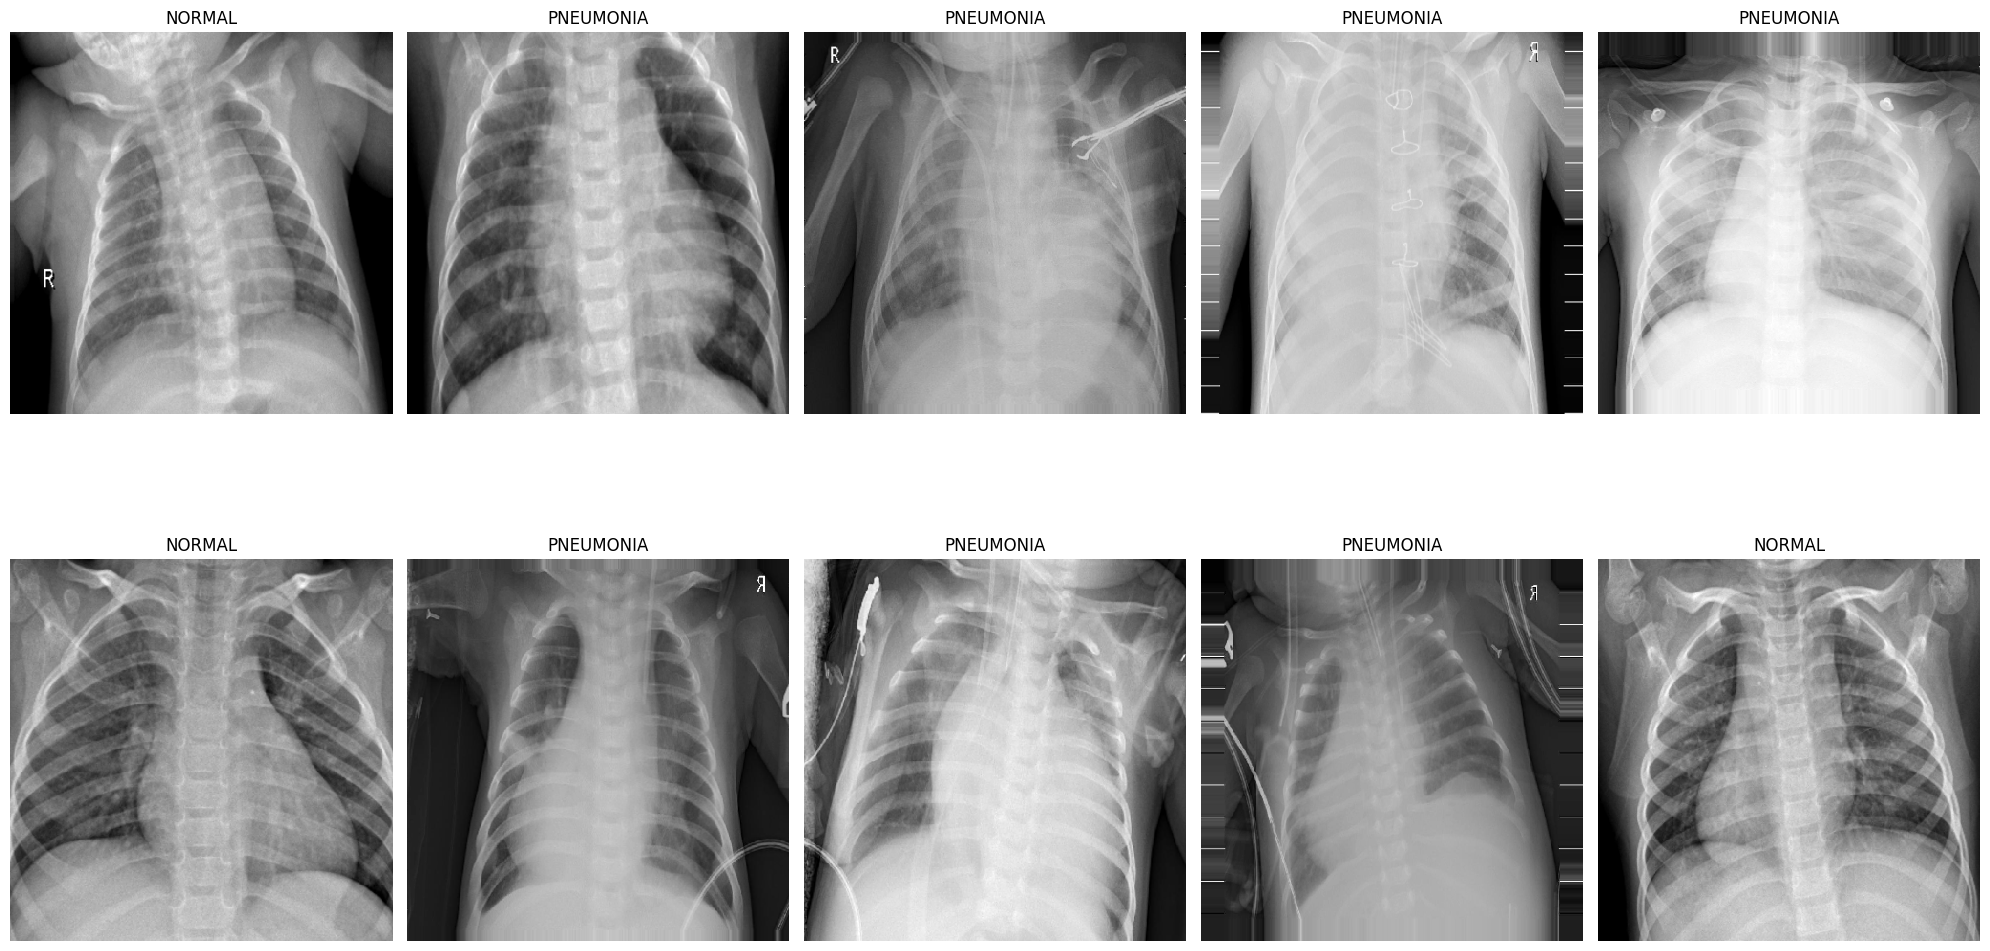

In [ ]:
plt.figure(figsize=(20, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]
        dic = {0:'NORMAL', 1:'PNEUMONIA'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

### Define

In [ ]:
'''        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening

        rotation_range = 15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False,# randomly flip images
        shear_range=0.2,
        brightness_range=(1.2, 1.5)'''

'        featurewise_center=False,  # set input mean to 0 over the dataset\n        samplewise_center=False,  # set each sample mean to 0\n        featurewise_std_normalization=False,  # divide inputs by std of the dataset\n        samplewise_std_normalization=False,  # divide each input by its std\n        zca_whitening=False,  # apply ZCA whitening\n\n        rotation_range = 15,  # randomly rotate images in the range (degrees, 0 to 180)\n        zoom_range = 0.2, # Randomly zoom image\n        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)\n        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)\n        horizontal_flip = True,  # randomly flip images\n        vertical_flip=False,# randomly flip images\n        shear_range=0.2,\n        brightness_range=(1.2, 1.5)'

## 3. Convolutional Neural Network Model

In [ ]:
# Sequential class is used to create a linear stack of layers for the neural network.
cnn = Sequential()

'''
Adding Convolutional Layers (Conv2D):
 -> Convolutional layers perform feature extraction from the input images.
 -> Multiple layers are beneficial as each layer learns different features from the input images.

Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)):
 -> This adds a 2D convolutional layer with 32 filters of size 3x3.
 -> The activation function used is the rectified linear unit (ReLU).
The input_shape parameter specifies the dimensions of the input images:
  -> (img_width, img_height, 1) represents a single-channel (grayscale) image.

Adding MaxPooling Layers (MaxPooling2D):
 -> Max-pooling layers reduce the spatial dimensions of the feature maps obtained from the convolutional layers
 -> Thus reducing the computational load and providing some translation invariance.
 -> MaxPooling2D(pool_size = (2, 2)): This adds a 2D max-pooling layer with a pool size of 2x2.
'''

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

# Flatten the 2D feature maps into a 1D vector.
# This prepares the data for passing through fully connected layers.
cnn.add(Flatten())

'''
Adding Dense (Fully Connected) Layers:
 -> These layers perform the final classification based on the features learned in the previous layers.

Dense(activation = 'relu', units = 128):
 -> Fully connected layer with 128 neurons and uses the ReLU activation function.
Dense(activation = 'relu', units = 64):
 -> Fully connected layer with 64 neurons and ReLU activation.
Dense(activation = 'sigmoid', units = 1):
 -> Output layer with a single neuron and sigmoid activation.
 -> Binary classification ( like pneumonia vs. normal )
    -> Sigmoid activation is commonly used as it produces a probability-like output.
'''
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))


cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 398, 398, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 199, 199, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 197, 197, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 98, 98, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 48, 48, 32)       0

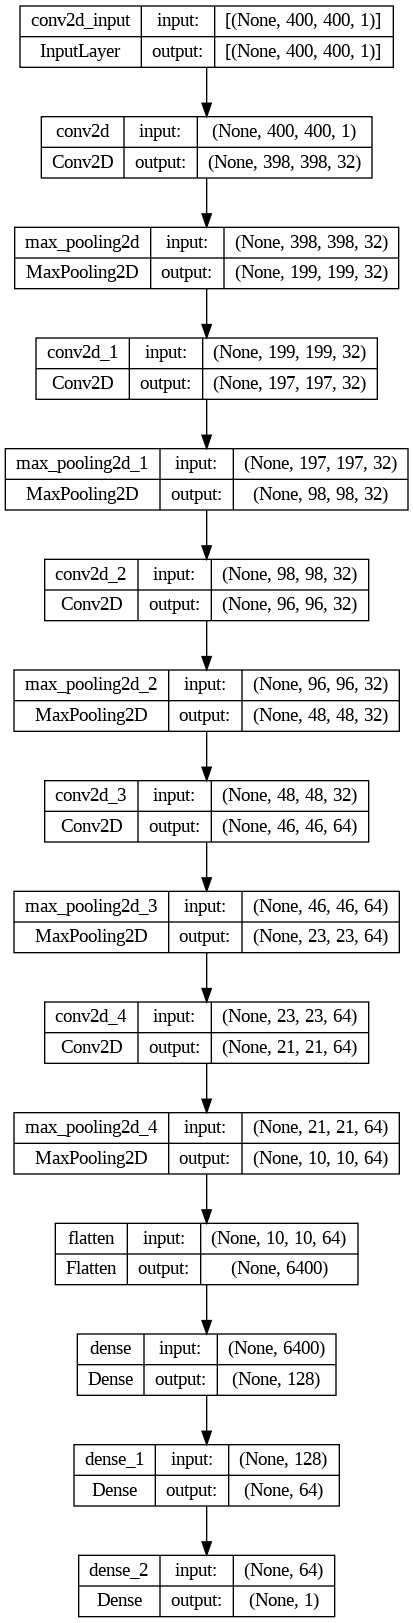

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

## 3.2 Fitting Model

In [ ]:
'''
Early stopping helps prevent overfitting :
 -> It waits for 3 "lessons" (epochs) where the LOSS doesn't improve much.
 -> Then it stops, as learning might not be getting better.
'''

early = EarlyStopping(monitor="val_loss", mode="min", patience=3)

'''
Imagine the computer is learning like a student. Sometimes, if the student isn't learning well,
we might slow down how much they're learning. Similar for a computer:

monitor='val_loss': It's watching the validation loss again.
patience=2: If the loss doesn't improve much for 2 lessons, it takes action.
verbose=1: It gives you some messages so you know what's happening.
factor=0.3: If the loss doesn't improve, it decreases the learning rate by 30%.
min_lr=0.000001: It makes sure the learning rate doesn't go below a very small value.

'''
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

'''
We're putting these two strategies (early stopping and learning rate reduction) together in a list
called callbacks_list. This list is like a set of helpful "helpers" that watch how well the computer is
learning. If things don't look good, they step in and make changes to help the computer learn better.
'''
callbacks_list = [ early, learning_rate_reduction]

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

'''
Class Weight Calculation: In machine learning, sometimes one class might have more examples than the other,
which can cause an imbalance. To address this, we assign different weights to classes.
In this case, compute_class_weight calculates class weights to balance the impact of different classes.

class_weight="balanced": This parameter tells the function to calculate class weights in a way that balances the classes.
classes=np.unique(train.classes): It identifies the UNIQUE CLASSES in the training data.
y=train.classes: It provides the ACTUAL CLASS LABELS from the training data to calculate the weights.
'''

weights = compute_class_weight(class_weight = "balanced", classes = np.unique(train.classes), y = train.classes)
#weights = compute_class_weight('balanced', np.unique(train.classes), train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 1.9371534195933457, 1: 0.6739549839228296}


In [ ]:
cnn.fit(train,epochs=5, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Epoch 1/5
262/262 [==============================] - 1189s 5s/step - loss: 0.4748 - accuracy: 0.7183 - val_loss: 0.2962 - val_accuracy: 0.9029 - lr: 0.0010
Epoch 2/5
262/262 [==============================] - 1223s 5s/step - loss: 0.2239 - accuracy: 0.9120 - val_loss: 0.3532 - val_accuracy: 0.8288 - lr: 0.0010
Epoch 3/5
262/262 [==============================] - 1164s 4s/step - loss: 0.1874 - accuracy: 0.9251 - val_loss: 0.2164 - val_accuracy: 0.9173 - lr: 0.0010
Epoch 4/5
262/262 [==============================] - 1216s 5s/step - loss: 0.1736 - accuracy: 0.9289 - val_loss: 0.2324 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 5/5
262/262 [==============================] - ETA: 0s - loss: 0.1734 - accuracy: 0.9280
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
262/262 [==============================] - 1165s 4s/step - loss: 0.1734 - accuracy: 0.9280 - val_loss: 0.3292 - val_accuracy: 0.8529 - lr: 0.0010


In [ ]:
fp = "cnn_pneu_vamp_model.h5"
cnn.save(fp)

In [ ]:
cnn = load_model(fp)

In [ ]:
cnn.predict_segmentation()

AttributeError: 'Sequential' object has no attribute 'predict_segmentation'

##3.3 Evaluation

In [ ]:
pd.DataFrame(cnn.history.history).plot()

AttributeError: 'NoneType' object has no attribute 'history'

In [ ]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

39/39 [==============================] - 45s 1s/step - loss: 0.2677 - accuracy: 0.8782
The testing accuracy is : 87.82051205635071 %


In [ ]:
preds = cnn.predict(test,verbose=1)

39/39 [==============================] - 45s 1s/step


In [ ]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

<Axes: >

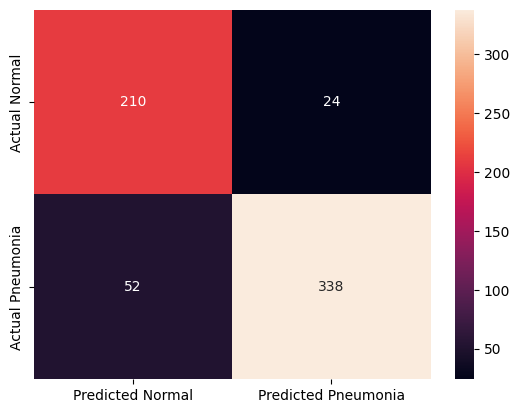

In [ ]:
# Confusion matrix helps plot actual vs model predictions to gauge accuracy
from sklearn.metrics import classification_report,confusion_matrix

cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),
                  index=["Actual Normal", "Actual Pneumonia"],
                  columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
 print(classification_report(y_true=test.classes, y_pred=predictions,
                            target_names =['NORMAL','PNEUMONIA']
 ))

              precision    recall  f1-score   support

      NORMAL       0.80      0.90      0.85       234
   PNEUMONIA       0.93      0.87      0.90       390

    accuracy                           0.88       624
   macro avg       0.87      0.88      0.87       624
weighted avg       0.88      0.88      0.88       624



In [ ]:
test.reset()
x=np.concatenate([test.next()[0] for i in range(test.__len__())])
y=np.concatenate([test.next()[1] for i in range(test.__len__())])
print(x.shape)
print(y.shape)

(624, 400, 400, 1)
(624,)


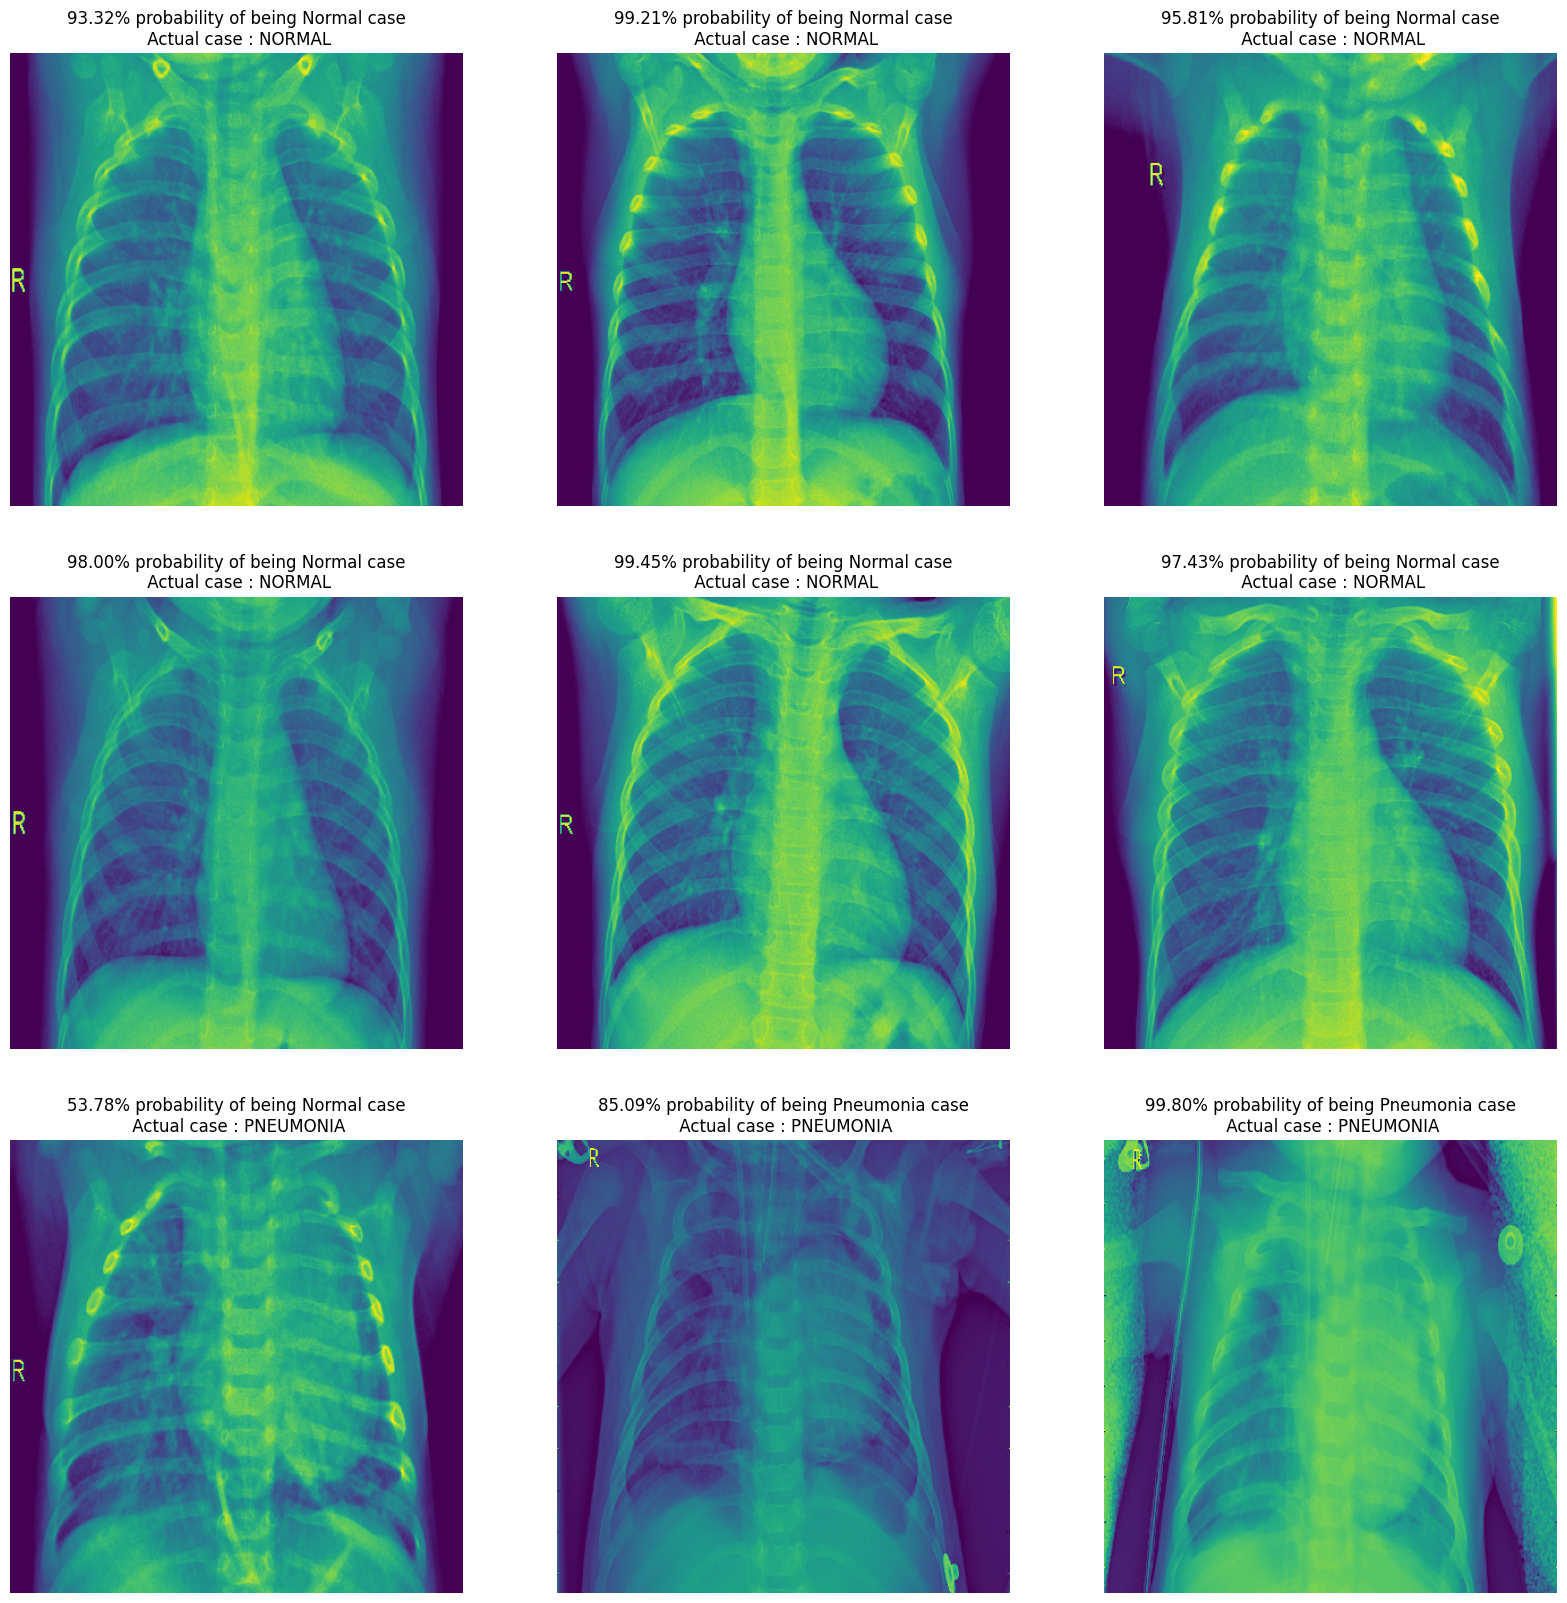

In [ ]:
dic = {0:'NORMAL', 1:'PNEUMONIA'}
plt.figure(figsize=(20,20))
for i in range(0+228, 9+228):
  plt.subplot(3, 3, (i-228)+1)
  if preds[i, 0] >= 0.5:
      out = ('{:.2%} probability of being Pneumonia case'.format(preds[i][0]))


  else:
      out = ('{:.2%} probability of being Normal case'.format(1-preds[i][0]))



  plt.title(out+"\n Actual case : "+ dic.get(y[i]))
  plt.imshow(np.squeeze(x[i]))
  plt.axis('off')
plt.show()

In [ ]:
'''import plotly.graph_objects as go
fig = go.Figure( go.Scatter(y=y ) )
fig.show()'''

In [ ]:
'''import plotly.graph_objects as go
fig = go.Figure( go.Scatter(y=predictions[:,0] ) )
fig.show()'''

In [ ]:
# Testing with my own Chest X-Ray
sample_path = '/content/drive/My Drive/unsegregated /IMG_20201023_204205928~2.jpg'

from tensorflow.keras.preprocessing import image

sample_img = image.load_img(sample_path, target_size=(500, 500),color_mode='grayscale')

# Preprocessing the image
pp_sample_img = image.img_to_array(sample_img)
pp_sample_img = pp_sample_img/255
pp_sample_img = np.expand_dims(pp_sample_img, axis=0)

#predict
sample_preds= cnn.predict(pp_sample_img)

#print
plt.figure(figsize=(6,6))
plt.axis('off')
if sample_preds>= 0.5:
    out = ('I am {:.2%} percent confirmed that this is a Pneumonia case'.format(sample_preds[0][0]))

else:
    out = ('I am {:.2%} percent confirmed that this is a Normal case'.format(1-sample_preds[0][0]))


plt.title("Sample Chest X-Ray\n"+out)
plt.imshow(np.squeeze(pp_hardik_img))
plt.show()

FileNotFoundError: ignored

# Streamlit app from a Google Colab Notebook
> Created by [Manuel Romero](https://twitter.com/mrm8488)

In [ ]:
!pip install -q streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.8 MB/s eta 0:00:00


In [ ]:
!pip install h5py

Reset the execution environment after streamlit installation

## Download a streamlit app example

This example comes from [How to Build a Simple Machine Learning Web App in Python](https://www.youtube.com/watch?v=8M20LyCZDOY) and it will create a **Simple Iris Flower Prediction App**

In [ ]:
!wget https://raw.githubusercontent.com/smarthardik10/Medical-X-ray-Image-Classification-using-Convolutional-Neural-Network/main/webapp.py

--2024-04-12 10:50:56--  https://raw.githubusercontent.com/smarthardik10/Medical-X-ray-Image-Classification-using-Convolutional-Neural-Network/main/webapp.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1607 (1.6K) [text/plain]
Saving to: ‘webapp.py’

webapp.py           100%[===================>]   1.57K  --.-KB/s    in 0s      

2024-04-12 10:50:57 (15.4 MB/s) - ‘webapp.py’ saved [1607/1607]



## OR

## Install ngrok

Ngrok is a tool that allows you to expose a local server or web application running on your local machine to the internet. It creates a secure tunnel from a public endpoint on the ngrok servers to a locally running web service. This is especially useful for testing and demonstrating applications or websites that are still in development on your local machine.

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip

--2024-04-12 10:51:01--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 18.205.222.128, 54.161.241.46, 54.237.133.81, ...
Connecting to bin.equinox.io (bin.equinox.io)|18.205.222.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13921656 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.28M  37.6MB/s    in 0.4s    

2024-04-12 10:51:02 (37.6 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13921656/13921656]



In [ ]:
!unzip ngrok-stable-linux-amd64.zip

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [ ]:
ngrok_token = "2UQJCBgNYKOZ5l6pMJVFzE8VX88_2AAPQikrPkRv1MDGrvHEu"
!./ngrok authtoken $ngrok_token

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
%%writefile webapp.py

import streamlit as st
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model
import tensorflow as tf
import time
from tempfile import NamedTemporaryFile
from tensorflow.keras.preprocessing import image

st.set_page_config(layout='wide')

st.set_option('deprecation.showfileUploaderEncoding', False)
@st.cache(allow_output_mutation=True)
def loading_model():
  fp = "./drive/My Drive/cnn_pneu_vamp_model.h5"
  model_loader = load_model(fp)
  return model_loader

cnn = loading_model()

st.title(""" X-Ray Classification for Pneumonia Detection """)
st.info(
"""
Final Project 2 - By Vedanth Aggarwal | Built using tensorflow covolutional neural networks\n
**Remember that the detection model is a tool and not a substitute for professional medical advice. If you have ongoing health concerns, it's best to consult with a medical professional to ensure accurate diagnosis and appropriate care**
"""
)
st.write('<hr style="height:3px;border:none;color:#333;background-color:#333;" />', unsafe_allow_html=True)

temp = st.file_uploader("Upload ( or drag & drop ) X-Ray Image",label_visibility='collapsed')

col_a,col_b = st.columns([0.5,0.5])

buffer = temp
temp_file = NamedTemporaryFile(delete=False)

if buffer : # buffer
  try:
    temp_file.write(buffer.getvalue())
    with col_a:
      st.write(image.load_img(temp_file.name))
    with col_b:
      progress_bar = st.progress(0)

    for i in range(0,35):
        time.sleep(0.1)
        progress_bar.progress(i,'Loading Image ....')

    chosen_img = image.load_img(temp_file.name, target_size=(250, 250),color_mode='grayscale')

    for i in range(35,70):
          time.sleep(0.2)
          progress_bar.progress(i,'Processing Image ....')
      # Preprocessing the image
    pp_chosen_img = image.img_to_array(chosen_img)
    #colormap = cm.get_cmap('jet')
    #chosen_colormap_img = colormap(chosen_img_array.squeeze())[:, :, :3]  # Discard the alpha channel
    pp_chosen_img = pp_chosen_img/255
    pp_chosen_img = np.expand_dims(pp_chosen_img, axis=0)

    for i in range(70,95):
          time.sleep(0.1)
          progress_bar.progress(i,'Making Prediction ....')

    #predict
    image_preds= cnn.predict(pp_chosen_img)

    col1,col2 = st.columns(2)

    for i in range(95,101):
          time.sleep(0.1)
          progress_bar.progress(i,'Process succesful ....')
    pneu_msg_1 = '''
  **Dangerous threat of disease! Consider taking the following steps:**
  1. Consult a Medical Professional
  2. Get a Clinical Examination
  3. Follow Treatment Recommendations - If pneumonia is confirmed, your healthcare provider will recommend a tailored treatment plan. This may include prescription medications such as antibiotics or antiviral drugs, as well as rest, hydration, and other supportive measures. Follow your doctor's advice closely to aid in your recovery.
  4. Monitor and Rest - Pneumonia can vary in severity, so it's important to monitor your symptoms and follow medical guidance. Get plenty of rest to allow your body to recover. If your symptoms worsen, such as increased difficulty breathing or persistent high fever, seek immediate medical attention.
      '''

    pneu_msg_2 = '''
  **Prediction is not definitive, Further confirmation is required!!! Consider taking the following steps:**
  1. Consult a Healthcare Professionalrofessional
  2. Monitor Your Symptoms - Pay close attention to any symptoms you may be experiencing, such as coughing, difficulty breathing, fever, or chest discomfort. Keep a record of your symptoms and any changes you notice. If your symptoms worsen or persist, seek medical attention promptly.
  3. Practice Self-Care
  4. Consider Getting Tested
  5. Follow Medical Recommendations
  6. Stay Informed
      '''

    normal_msg_1 = '''
    **Prediction is not definitive, Further confirmation required! Consider following precuations:**
  1. Monitor Your Health and pay attention to any changes in your symptoms
  2. Practice Preventive Measures - Maintain good hygiene practices, such as washing your hands regularly, covering your mouth and nose when sneezing or coughing, and avoiding close contact with individuals who are sick. These measures help prevent the spread of infections, including respiratory illnesses.
  3. Stay Active and Healthy - Engage in regular physical activity, maintain a balanced diet, and get sufficient sleep.
  4. Stay Informedy
  5. Seek Medical Advice if Symptoms Persist
  6. Follow Healthcare Provider's Advice
      '''

    normal_msg_2 = '''
    **You are safe, but maintain the following:**
  1. Consult a Healthcare Professional
  2. Follow Medical Advice
  3. Monitor Your Healthevelopments
  4. Practice Precautions
  5. Stay Hydrated and Rest
  6. Avoid Self-Medication
  7. Stay Informed
  8. Follow Up with Medical Professionals
  '''


    with col1:
      #st.write(image_preds)
      if image_preds >= 0.5:  # Normal or Pneumonia
          percentage = image_preds[0][0]
          if percentage > 0.9:
              st.error('**Picture is {:.2f}% case of Pneumonia!!!\n{}**'.format(percentage * 100, pneu_msg_1))
          else:
              st.warning('**Picture is {:.2f}% case of Pneumonia!\n{}**'.format(percentage * 100, pneu_msg_2))
      else:
          percentage = 1 - image_preds[0][0]
          if percentage > 0.9:
              st.success('**Picture is {:.2f}% NOT a case of Pneumonia!!!{}**'.format(percentage * 100, normal_msg_1))
              st.balloons()
          else:
              st.warning('**Picture is {:.2f}% NOT a case of Pneumonia!{}**'.format(percentage * 100, normal_msg_2))

    with col2:
        image = Image.open(temp)
        st.image(image,use_column_width=True)



  except Exception as e:
    st.error(f'Pls upload a valid file format first!!! {e}')

Overwriting webapp.py


In [ ]:
'''
%%writefile webapp.py

import streamlit as st
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model
import tensorflow as tf
import time
from tempfile import NamedTemporaryFile
from tensorflow.keras.preprocessing import image

st.set_page_config(layout='wide')

st.set_option('deprecation.showfileUploaderEncoding', False)
@st.cache(allow_output_mutation=True)
def loading_model():
  fp = "./drive/My Drive/cnn_pneu_vamp_model.h5"
  model_loader = load_model(fp)
  return model_loader

cnn = loading_model()

st.title(""" X-Ray Classification for Pneumonia Detection """)
st.info('Final Project 2 - By Vedanth Aggarwal | Built using tensorflow covolutional neural networks ')
st.write('<hr style="height:3px;border:none;color:#333;background-color:#333;" />', unsafe_allow_html=True)

colx,coly = st.columns([0.8,0.2])

with colx:
  temp = st.file_uploader("Upload ( or drag & drop ) X-Ray Image",label_visibility='collapsed')
with coly:
  start_pred = st.button('PREDICT',type='primary')

col_a,col_b = st.columns([0.3,0.7])
buffer = temp
temp_file = NamedTemporaryFile(delete=False)

if start_pred: # buffer
    temp_file.write(buffer.getvalue())
    with col
    st.write(image.load_img(temp_file.name))

  progress_bar = st.progress(0)
  for i in range(0,35):
      time.sleep(0.2)
      progress_bar.progress(i,'Loading Image ....')
  chosen_img = image.load_img(temp_file.name, target_size=(250, 250),color_mode='grayscale')

  for i in range(35,70):
      time.sleep(0.2)
      progress_bar.progress(i,'Processing Image ....')
  # Preprocessing the image
  pp_chosen_img = image.img_to_array(chosen_img)
  pp_hardik_img = pp_chosen_img/255
  pp_chosen_img = np.expand_dims(pp_chosen_img, axis=0)

  for i in range(70,95):
      time.sleep(0.2)
      progress_bar.progress(i,'Making Prediction ....')

  #predict
  image_preds= cnn.predict(pp_chosen_img)
  percentage = round(image_preds[0][0],2)

  col1,col2 = st.columns(2)

  with col1:
    if image_preds>= 0.5: # Normal or Pneumonia
      if percentage > 0.80:
        st.error(f'Picture is {percentage}% case of Pneumonia!!!\nConsult doctor immediately!')
      else :
        st.warning(f'Picture is {percentage}% case of Pneumonia!\nFurther confirmation is required.')
    else:
      if percentage > 0.80:
        st.success(f'Picture is {percentage}% NOT a case of Pneumonia!!!\nYou are safe!')
        st.balloons()
      else :
        st.error(f'Picture is {percentage}% NOT a case of Pneumonia!\nFurther confirmation is required.')

  with col2:
    image = Image.open(temp)
    st.image(image,use_column_width=True)
'''

'\n%%writefile webapp.py\n\nimport streamlit as st\nimport numpy as np\nfrom PIL import Image\nfrom tensorflow.keras.models import load_model\nimport tensorflow as tf\nimport time\nfrom tempfile import NamedTemporaryFile\nfrom tensorflow.keras.preprocessing import image\n\nst.set_page_config(layout=\'wide\')\n\nst.set_option(\'deprecation.showfileUploaderEncoding\', False)\n@st.cache(allow_output_mutation=True)\ndef loading_model():\n  fp = "./drive/My Drive/cnn_pneu_vamp_model.h5"\n  model_loader = load_model(fp)\n  return model_loader\n\ncnn = loading_model()\n\nst.title(""" X-Ray Classification for Pneumonia Detection """)\nst.info(\'Final Project 2 - By Vedanth Aggarwal | Built using tensorflow covolutional neural networks \')\nst.write(\'<hr style="height:3px;border:none;color:#333;background-color:#333;" />\', unsafe_allow_html=True)\n\ncolx,coly = st.columns([0.8,0.2])\n\nwith colx:\n  temp = st.file_uploader("Upload ( or drag & drop ) X-Ray Image",label_visibility=\'collapsed\'

In [ ]:
%%writefile webapp.py
import streamlit as st
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model
import tensorflow as tf

from tempfile import NamedTemporaryFile
from tensorflow.keras.preprocessing import image

st.set_option('deprecation.showfileUploaderEncoding', False)
@st.cache(allow_output_mutation=True)

def loading_model():
  fp = "./drive/My Drive/cnn_pneu_vamp_model.h5"
  model_loader = load_model(fp)
  return model_loader

cnn = loading_model()
st.write("""
# X-Ray Classification (Pneumonia/Normal)
""")






temp = st.file_uploader("Upload X-Ray Image")

buffer = temp
temp_file = NamedTemporaryFile(delete=False)
if buffer:
    temp_file.write(buffer.getvalue())
    st.write(image.load_img(temp_file.name))


if buffer is None:
  st.text("Oops! that doesn't look like an image. Try again.")

else:



  hardik_img = image.load_img(temp_file.name, target_size=(400, 400),color_mode='grayscale')

  # Preprocessing the image
  pp_hardik_img = image.img_to_array(hardik_img)
  pp_hardik_img = pp_hardik_img/255
  pp_hardik_img = np.expand_dims(pp_hardik_img, axis=0)

  #predict
  hardik_preds= cnn.predict(pp_chosen_img)
  if hardik_preds>= 0.5:
    out = ('I am {:.2%} percent confirmed that this is a Pneumonia case'.format(hardik_preds[0][0]))

  else:
    out = ('I am {:.2%} percent confirmed that this is a Normal case'.format(1-hardik_preds[0][0]))

  st.success(out)

  image = Image.open(temp)
  st.image(image,use_column_width=True)

Overwriting webapp.py


In [ ]:
get_ipython().system_raw('./ngrok http 8501 &')

In [ ]:
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    'import sys, json; print("Execute the next cell and the go to the following URL: " +json.load(sys.stdin)["tunnels"][0]["public_url"])'

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/usr/lib/python3.10/json/__init__.py", line 293, in load
    return loads(fp.read(),
  File "/usr/lib/python3.10/json/__init__.py", line 346, in loads
    return _default_decoder.decode(s)
  File "/usr/lib/python3.10/json/decoder.py", line 337, in decode
    obj, end = self.raw_decode(s, idx=_w(s, 0).end())
  File "/usr/lib/python3.10/json/decoder.py", line 355, in raw_decode
    raise JSONDecodeError("Expecting value", s, err.value) from None
json.decoder.JSONDecodeError: Expecting value: line 1 column 1 (char 0)


In [ ]:
!ngrok config add-authtoken 2UQJCBgNYKOZ5l6pMJVFzE8VX88_2AAPQikrPkRv1MDGrvHEu

/bin/bash: line 1: ngrok: command not found


In [ ]:
!streamlit run /content/webapp.py




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.71.8.97:8501

  Stopping...
  Stopping...


[![ko-fi](https://www.ko-fi.com/img/githubbutton_sm.svg)](https://ko-fi.com/Y8Y3VYYE)